# Pyemcee3
## Joining Emcee with Pymc3
Author: [Shaun Read](https://github.com/philastrophist/)

[Emcee](http://dan.iel.fm/emcee/current/) is a python implementation of [Goodman & Weare’s Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler](http://msp.berkeley.edu/camcos/2010/5-1/p04.xhtml). It succeeds where other samplers fail in sampling hard posteriors and uses an ensemble of walkers (inter-communicating chains). Emcee is very popular and [has been tagged onto Pymc in the past](http://msp.berkeley.edu/camcos/2010/5-1/p04.xhtml), here Pymc3 supports Emcee as an additional step function imported from `pymc3.externals`.

## An example: Fitting a straight line

In [39]:
import numpy as np
import matplotlib.pyplot as plt

true_gradient = 2
true_intercept = 3
true_variance = 0.5

x = np.linspace(0, 1, 50)
y = true_intercept + (x*true_gradient)
y += np.random.normal(0, np.sqrt(true_variance), size=len(x))
yerr = np.ones_like(y) * 0.1  # noisy straight line with badly specified uncertainties

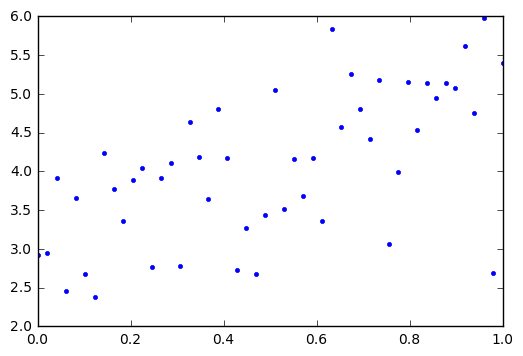

In [40]:
%matplotlib inline
plt.plot(x, y, 'b.');

## Fitting a straight line in emcee

In [41]:
def lnlike(theta, x, y, yerr):
    m, c, lnf = theta
    model = m * x + c
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [42]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [true_gradient, true_intercept, true_variance], args=(x, y, yerr))

In [43]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [44]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(x, y, yerr))
sampler.run_mcmc(pos, 1000);

Select a burntin selection of 1950 samples

In [45]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

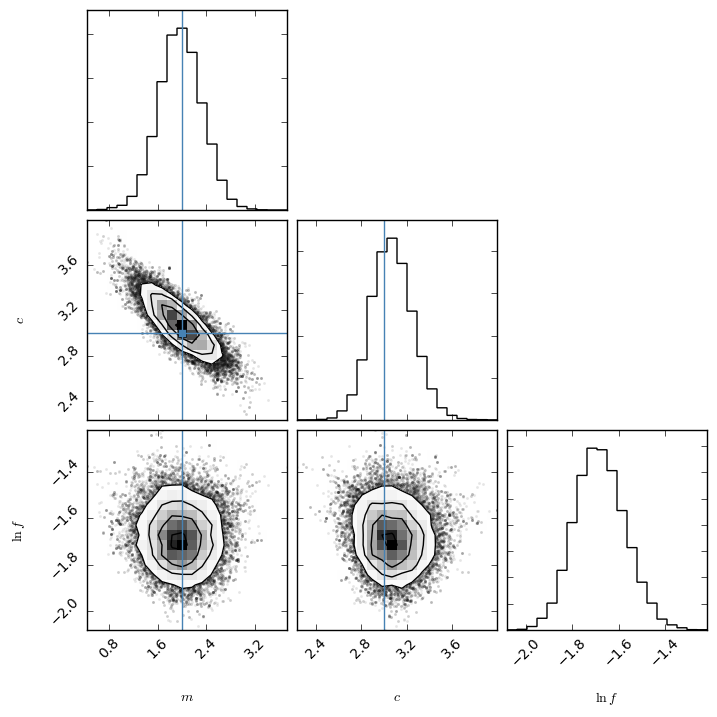

In [48]:
import corner
corner.corner(samples, labels=["$m$", "$c$", "$\ln\,f$"], truths=[true_gradient, true_intercept, np.log(true_variance)]);

## The same with Pymc3+Emcee!
With no changes to the api, we can use Emcee and pymc3's clever initialiser, ADVI. Therefore, we can avoid all the tedious model specifications and walker randomisation that we have to do when just using Emcee!

In [49]:
import pymc3 as pm

In [77]:
from pymc3.external.emcee_samplers import EmceeEnsemble
# new import from externals (you need to install emcee separately)

Here we force pymc3 

In [84]:
import theano.tensor as tt

with pm.Model() as model:
    eps = pm.HalfCauchy('eps', beta=10)
    intercept = pm.Normal('intercept', mu=0, sd=10)
    gradient = pm.Normal('gradient', mu=0, sd=10)
    line = pm.Deterministic('line', intercept + (x * gradient))
    inv_sigma2 = 1.0/(yerr**2 + line**2*tt.exp(2*tt.log(eps)))
    like = pm.Potential('like', -0.5*(tt.sum((y-line)**2*inv_sigma2 - tt.log(inv_sigma2))))

Pymc3 will initialise emcee starting points by itself: no need to specifiy, but you can if you want (see below).

In [86]:
with model:
    trace = pm.sample(1000, step=EmceeEnsemble(nparticles=100))

Initializing using advi...
Average ELBO = -270.76: 100%|█████████████████████████████| 200000/200000 [00:11<00:00, 17971.07it/s]
Finished [100%]: Average ELBO = -271.09
100%|███████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.49it/s]


In [ ]:
pm.traceplot(trace, ['eps', 'intercept', 'gradient'], lines={'gradient': true_gradient, 'intercept': true_intercept, 
                                                            'eps': true_variance}, combined=True);

In [ ]:
samples = np.stack([trace['gradient'], trace['intercept'], trace['eps']]).T

In [ ]:
corner.corner(samples, labels=["$m$", "$c$", "$\ln\,f$"], truths=[true_gradient, true_intercept, np.log(true_variance)]);